In [1]:
import tensorflow as tf
import numpy as np

In [2]:
IMG_SIZE = 32
NUM_CLASSES = 100
BATCH_SIZE = 128
EPOCHS = 50

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()

y_train = y_train.squeeze()
y_test = y_test.squeeze()

In [4]:
def random_resized_crop(image):
    crop_size = tf.random.uniform(
        [], int(0.6 * IMG_SIZE), IMG_SIZE, dtype=tf.int32
    )
    image = tf.image.random_crop(image, [crop_size, crop_size, 3])
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    return image


In [5]:
def color_jitter(image):
    image = tf.image.random_brightness(image, 0.2)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    return tf.clip_by_value(image, 0.0, 1.0)


In [6]:
def rand_augment(image):
    op = tf.random.uniform([], 0, 3, dtype=tf.int32)

    image = tf.cond(
        op == 0,
        lambda: tf.image.random_flip_left_right(image),
        lambda: image
    )
    image = tf.cond(
        op == 1,
        lambda: tf.image.random_saturation(image, 0.6, 1.4),
        lambda: image
    )
    image = tf.cond(
        op == 2,
        lambda: tf.image.random_hue(image, 0.08),
        lambda: image
    )
    return image


In [7]:
def weak_preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.random_flip_left_right(image)
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


In [8]:
def strong_preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = random_resized_crop(image)
    image = color_jitter(image)
    image = rand_augment(image)
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


In [9]:
def mixup(images, labels, alpha=0.2):
    batch_size = tf.shape(images)[0]
    lam = tf.random.uniform([], 0, 1)

    indices = tf.random.shuffle(tf.range(batch_size))
    mixed_images = lam * images + (1 - lam) * tf.gather(images, indices)
    mixed_labels = lam * labels + (1 - lam) * tf.gather(labels, indices)

    return mixed_images, mixed_labels


In [10]:
# Weak Dataset
train_ds_weak = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds_weak = train_ds_weak.shuffle(50000)
train_ds_weak = train_ds_weak.map(weak_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_ds_weak = train_ds_weak.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

2026-01-16 20:02:02.564074: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2026-01-16 20:02:02.564101: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2026-01-16 20:02:02.564104: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.66 GB
2026-01-16 20:02:02.564124: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-01-16 20:02:02.564133: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [11]:
# Strong Dataset
train_ds_strong = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds_strong = train_ds_strong.shuffle(50000)
train_ds_strong = train_ds_strong.map(strong_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_ds_strong = train_ds_strong.batch(BATCH_SIZE)
train_ds_strong = train_ds_strong.map(mixup, num_parallel_calls=tf.data.AUTOTUNE)
train_ds_strong = train_ds_strong.prefetch(tf.data.AUTOTUNE)

In [12]:
def val_preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

val_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_ds = val_ds.map(val_preprocess)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [13]:
def build_model():
    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    x = tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu")(inputs)
    x = tf.keras.layers.MaxPooling2D()(x)

    x = tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D()(x)

    x = tf.keras.layers.Conv2D(256, 3, padding="same", activation="relu")(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)

    model = tf.keras.Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.SGD(0.1, momentum=0.9),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        metrics=["accuracy"]
    )
    return model


In [14]:
model_weak = build_model()
model_weak.fit(train_ds_weak, epochs=EPOCHS)


Epoch 1/50


2026-01-16 20:02:54.017415: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.0385 - loss: 4.3780
Epoch 2/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.1129 - loss: 3.9399
Epoch 3/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.1876 - loss: 3.6315
Epoch 4/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.2580 - loss: 3.3509
Epoch 5/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.3086 - loss: 3.1520
Epoch 6/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.3512 - loss: 2.9839
Epoch 7/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.3873 - loss: 2.8515
Epoch 8/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.4191 - loss: 2.7315
Epoch 9/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.4449 - loss: 2.6445
Epoch 10/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.4666 - loss: 2.5693
Epoch 11/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.4869 - loss: 2.5003
Epoch 12/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/ste

In [15]:
model_strong = build_model()
model_strong.fit(train_ds_strong, epochs=EPOCHS)


Epoch 1/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.0227 - loss: 4.5244
Epoch 2/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.0437 - loss: 4.4140
Epoch 3/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.0680 - loss: 4.3067
Epoch 4/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.0895 - loss: 4.2315
Epoch 5/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.1136 - loss: 4.1681
Epoch 6/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.1320 - loss: 4.1037
Epoch 7/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.1434 - loss: 4.0633
Epoch 8/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.1640 - loss: 3.9933
Epoch 9/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.1732 - loss: 3.9571
Epoch 10/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.1900 - loss: 3.9057
Epoch 11/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.1996 - loss: 3.8854
Epoch 12/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 

In [22]:
def overall_accuracy(model, dataset):
    correct = 0
    total = 0

    for images, labels in dataset:
        preds = tf.argmax(model(images, training=False), axis=1)
        labels = tf.argmax(labels, axis=1)

        correct += tf.reduce_sum(tf.cast(preds == labels, tf.int32)).numpy()
        total += labels.shape[0]

    return correct / total


In [23]:
val_acc_weak = overall_accuracy(model_weak, val_ds)
val_acc_strong = overall_accuracy(model_strong, val_ds)

print(f"Validation Accuracy (Weak):   {val_acc_weak:.4f}")
print(f"Validation Accuracy (Strong): {val_acc_strong:.4f}")

2026-01-16 20:30:25.332970: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation Accuracy (Weak):   0.5079
Validation Accuracy (Strong): 0.4484


2026-01-16 20:30:26.076788: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [16]:
def per_class_accuracy(model, dataset):
    correct = np.zeros(NUM_CLASSES)
    total = np.zeros(NUM_CLASSES)

    for images, labels in dataset:
        preds = tf.argmax(model(images, training=False), axis=1)
        labels = tf.argmax(labels, axis=1)

        for y_true, y_pred in zip(labels.numpy(), preds.numpy()):
            total[y_true] += 1
            if y_true == y_pred:
                correct[y_true] += 1

    return correct / np.maximum(total, 1)


In [17]:
acc_weak = per_class_accuracy(model_weak, val_ds)
acc_strong = per_class_accuracy(model_strong, val_ds)

delta_a = acc_weak - acc_strong


2026-01-16 20:14:49.508758: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2026-01-16 20:14:49.988273: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [18]:
hurt_classes = np.argsort(delta_a)[-10:][::-1]

print("Most harmed classes (Δa_k):")
for k in hurt_classes:
    print(
        f"Class {k:3d} | Weak: {acc_weak[k]:.3f} | "
        f"Strong: {acc_strong[k]:.3f} | Δa_k: {delta_a[k]:.3f}"
    )


Most harmed classes (Δa_k):
Class  31 | Weak: 0.490 | Strong: 0.090 | Δa_k: 0.400
Class  96 | Weak: 0.470 | Strong: 0.090 | Δa_k: 0.380
Class  79 | Weak: 0.550 | Strong: 0.240 | Δa_k: 0.310
Class  95 | Weak: 0.740 | Strong: 0.450 | Δa_k: 0.290
Class  58 | Weak: 0.620 | Strong: 0.340 | Δa_k: 0.280
Class   2 | Weak: 0.500 | Strong: 0.230 | Δa_k: 0.270
Class  27 | Weak: 0.470 | Strong: 0.210 | Δa_k: 0.260
Class  45 | Weak: 0.470 | Strong: 0.220 | Δa_k: 0.250
Class  36 | Weak: 0.640 | Strong: 0.410 | Δa_k: 0.230
Class   4 | Weak: 0.340 | Strong: 0.110 | Δa_k: 0.230


In [19]:
import pandas as pd

table = pd.DataFrame({
    "Class ID": np.arange(NUM_CLASSES),
    "Accuracy (Weak)": acc_weak,
    "Accuracy (Strong)": acc_strong,
    "Δa_k": delta_a
})

# Top 10 most harmed classes
table_hurt = table.sort_values("Δa_k", ascending=False).head(10)
table_hurt


,Class ID,Accuracy (Weak),Accuracy (Strong),Δa_k
31,31,0.49,0.09,0.40
96,96,0.47,0.09,0.38
79,79,0.55,0.24,0.31
95,95,0.74,0.45,0.29
58,58,0.62,0.34,0.28
2,2,0.50,0.23,0.27
27,27,0.47,0.21,0.26
45,45,0.47,0.22,0.25
4,4,0.34,0.11,0.23
36,36,0.64,0.41,0.23


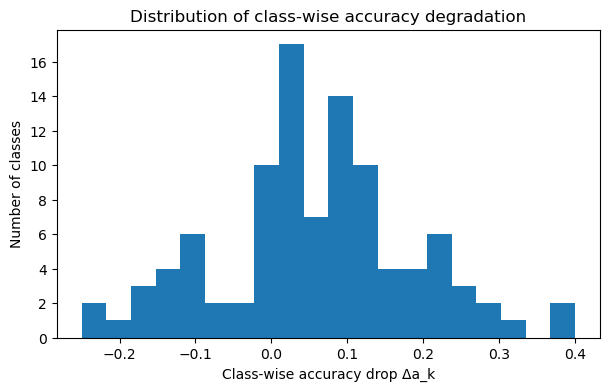

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 4))
plt.hist(delta_a, bins=20)
plt.xlabel("Class-wise accuracy drop Δa_k")
plt.ylabel("Number of classes")
plt.title("Distribution of class-wise accuracy degradation")
plt.show()


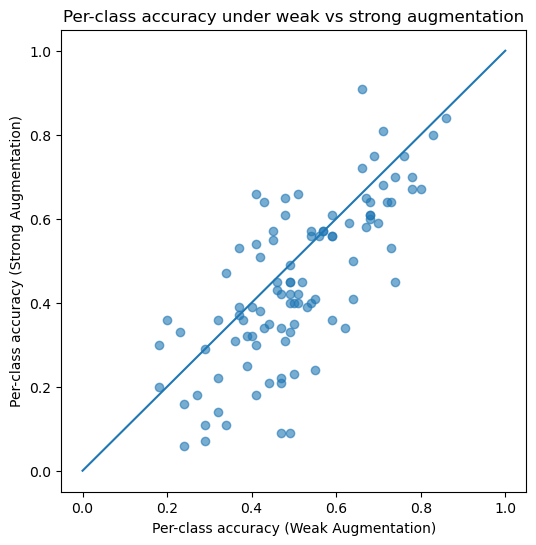

In [21]:
plt.figure(figsize=(6, 6))
plt.scatter(acc_weak, acc_strong, alpha=0.6)
plt.plot([0, 1], [0, 1])  # y = x reference
plt.xlabel("Per-class accuracy (Weak Augmentation)")
plt.ylabel("Per-class accuracy (Strong Augmentation)")
plt.title("Per-class accuracy under weak vs strong augmentation")
plt.show()
